* Files
* calendar.csv - Contains information about the dates on which the products are sold.
* sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
* sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from itertools import product                    # some useful functions
#from tqdm import tqdm_notebook
from tqdm import tqdm

## for Deep-learing:
from tensorflow import keras
import tensorflow as tf
from keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout, Flatten, TimeDistributed

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pip install keras-tcn

     |████████████████████████████████| 679 kB 35.2 MB/s 


In [ ]:
from tcn import TCN, tcn_full_summary, compiled_tcn, tcn
from tensorflow.keras.models import Sequential

In [ ]:
from keras import Input, Model
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D,  Dense, concatenate, Multiply
from keras.activations import relu


# Load Datasets

In [ ]:
calender= pd.read_csv('/content/drive/MyDrive/Data/calendar.csv')
calender.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
sales = pd.read_csv('/content/drive/MyDrive/Data/sales_train_evaluation.csv')
sales.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1


In [ ]:
sales.shape

(30490, 1947)

In [ ]:
sales_dept = sales.groupby('dept_id').sum()
sales_dept.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
dept_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1,2343,2216,1657,1508,1209,1897,1903,2235,1925,1586,1785,1737,2048,2349,2948,3688,2193,1552,1617,1502,1866,2391,2164,1784,1480,1587,1542,1744,2432,2019,1464,1691,1588,1626,1759,2193,2301,1540,1456,1482,...,2591,2583,3192,3523,3062,2461,2544,2657,2639,3169,3712,3185,2841,2860,2799,3184,3800,4415,4285,3506,4020,3602,3759,3925,4951,3895,3417,3306,3262,3252,4130,4257,4225,3264,3119,3073,3251,3735,4195,4031
FOODS_2,4094,4209,3174,3606,2869,4375,3349,4384,4273,3684,3255,3696,3592,3743,4722,4889,3021,3899,3219,2790,3030,3821,3853,3184,2598,2548,2463,2648,3499,3881,3028,3344,3245,3472,3310,4432,5162,3709,3480,3460,...,5124,5518,5661,5792,6588,5247,4942,4734,4446,4974,5524,6473,4957,4662,4111,4089,4973,5781,7129,6384,6296,5410,5906,5897,6997,6188,7531,5873,6537,5982,5842,7563,9069,6226,5311,4648,4551,4815,5940,6535
FOODS_3,16741,16333,12343,13764,10525,15821,15238,21132,18664,13631,11923,12222,11700,12946,17517,18079,10801,11974,10515,9998,11698,14726,14011,11405,9965,9797,9728,11088,13974,14760,10574,11533,11385,12144,12443,16447,17446,12339,11344,11097,...,16173,17355,19829,22692,24847,18443,17462,16241,16232,18561,22691,22996,18155,15997,15962,15642,18895,22527,23955,19252,19278,18187,18528,20585,24804,21752,21958,18152,19504,18908,20135,24756,28153,19668,17718,17069,16935,19586,23464,25401
HOBBIES_1,3610,3172,2497,2531,1714,3133,2855,3831,2741,2514,2412,2355,2524,2698,3567,3221,2106,2389,2031,1915,2131,3985,2809,2532,2344,2619,2424,2505,3918,1917,1595,1666,1507,1738,1480,1881,3579,2512,2363,2787,...,3182,3366,3367,4220,4325,3038,3420,3141,3014,3678,4397,4226,3389,3217,3236,3253,3649,4627,4322,3595,3907,3190,3195,3412,4448,3606,3514,3172,3384,3256,3422,4414,4464,3109,3142,3291,3027,3761,4832,4720
HOBBIES_2,154,185,185,138,100,87,89,155,158,101,135,102,176,124,132,196,127,165,139,134,153,157,169,203,115,139,135,170,170,201,176,167,168,117,173,215,216,175,156,168,...,375,420,419,414,495,285,367,331,339,407,390,457,393,428,494,489,436,587,536,464,466,518,607,467,555,456,381,416,433,450,449,479,552,419,487,449,448,382,501,560


In [ ]:
sales_item = sales.groupby('item_id').sum()
sales_item.head(3)

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6,6,4,6,7,18,10,4,11,10,6,5,12,15,16,18,11,10,12,7,17,9,9,8,5,14,26,8,12,13,5,11,10,14,11,8,22,14,6,9,...,6,3,4,4,30,7,5,3,6,2,16,6,4,5,7,1,9,3,9,1,10,3,1,6,10,6,2,5,6,2,7,8,8,4,7,7,5,7,5,9
FOODS_1_002,4,5,7,4,3,4,1,7,2,4,4,3,1,5,8,5,1,3,2,0,4,5,4,2,2,4,3,5,7,3,3,4,7,7,3,4,11,0,1,1,...,5,4,5,9,4,1,3,5,5,3,3,1,9,4,3,4,5,7,2,5,6,3,2,4,5,3,1,6,3,10,5,8,7,2,6,5,0,6,6,4
FOODS_1_003,14,8,3,6,3,8,13,10,11,6,11,10,3,17,20,14,10,9,3,14,7,23,16,7,12,6,5,7,10,6,10,6,8,3,9,18,18,11,8,4,...,4,1,7,3,5,6,3,4,4,3,11,5,7,13,9,1,2,4,7,9,2,3,13,5,9,5,0,6,3,10,7,8,6,11,9,7,7,10,6,5


In [ ]:
sales_item.shape

(3049, 1941)

In [ ]:
sales_cat = sales.groupby('cat_id').sum().T
sales_cat.head(3)

cat_id,FOODS,HOBBIES,HOUSEHOLD
d_1,23178,3764,5689
d_2,22758,3357,5634
d_3,17174,2682,3927


In [ ]:
sales_cat.index

Index(['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10',
       ...
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object', length=1941)

In [ ]:
sales_cat.shape

(1941, 3)

In [ ]:
sales_state = sales.groupby('state_id').sum().T
sales_state.head()

state_id,CA,TX,WI
d_1,14195,9438,8998
d_2,13805,9630,8314
d_3,10108,6778,6897
d_4,11047,7381,6984
d_5,9925,5912,3309


In [ ]:
sales_cat['days'] = sales_cat.index
sales_state['days'] = sales_state.index

In [ ]:
calender = calender.loc[:,['date','d']]

In [ ]:
calender.head()

,date,d
0,2011-01-29,d_1
1,2011-01-30,d_2
2,2011-01-31,d_3
3,2011-02-01,d_4
4,2011-02-02,d_5


In [ ]:
calender.tail()

,date,d
1964,2016-06-15,d_1965
1965,2016-06-16,d_1966
1966,2016-06-17,d_1967
1967,2016-06-18,d_1968
1968,2016-06-19,d_1969


In [ ]:

sales_cat = pd.merge(calender,sales_cat,how = 'inner', left_on = 'd', right_on = 'days')

sales_cat['date'] = pd.to_datetime(sales_cat['date'])

sales_cat = sales_cat.set_index('date')


In [ ]:
sales_state = pd.merge(calender,sales_state,how = 'inner', left_on = 'd', right_on = 'days')

sales_state['date'] = pd.to_datetime(sales_state['date'])

sales_state = sales_state.set_index('date')

In [ ]:
sales_cat.drop(columns=['days'], inplace=True)
sales_state.drop(columns=['days'], inplace=True)

In [ ]:
sales_cat.head()

,d,FOODS,HOBBIES,HOUSEHOLD
date,,,,
2011-01-29,d_1,23178,3764,5689
2011-01-30,d_2,22758,3357,5634
2011-01-31,d_3,17174,2682,3927
2011-02-01,d_4,18878,2669,3865
2011-02-02,d_5,14603,1814,2729


In [ ]:
sales_state.head()

,d,CA,TX,WI
date,,,,
2011-01-29,d_1,14195,9438,8998
2011-01-30,d_2,13805,9630,8314
2011-01-31,d_3,10108,6778,6897
2011-02-01,d_4,11047,7381,6984
2011-02-02,d_5,9925,5912,3309


In [ ]:
sales_overall = pd.DataFrame(sales_cat.sum(axis = 1), columns=['total_sales'])

In [ ]:
sales_overall.head()

,total_sales
date,
2011-01-29,32631
2011-01-30,31749
2011-01-31,23783
2011-02-01,25412
2011-02-02,19146


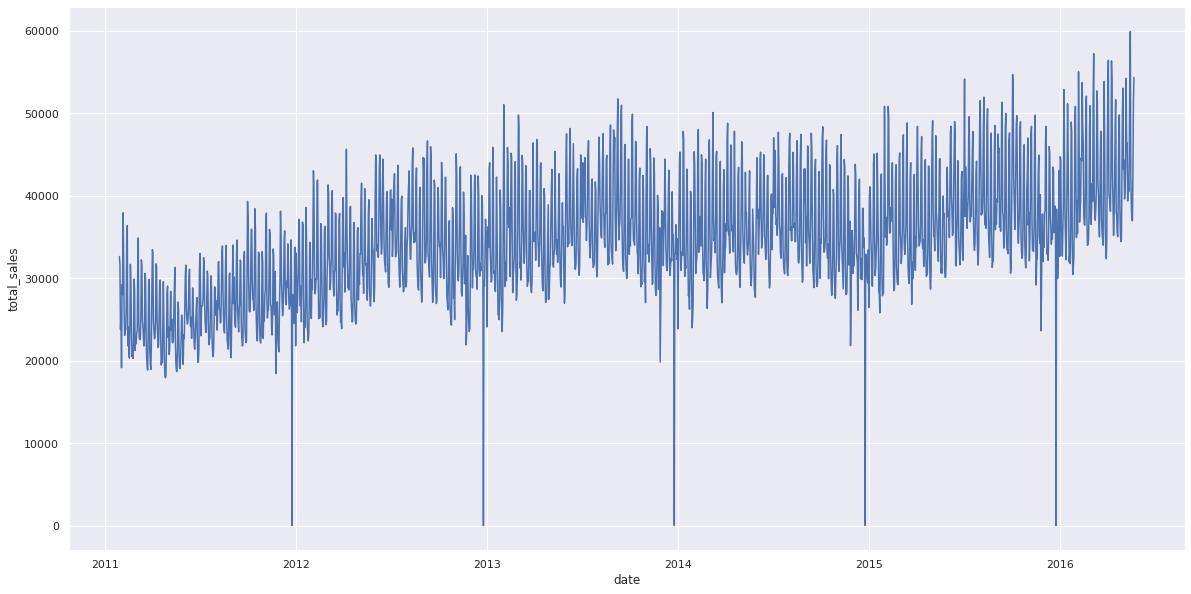

In [ ]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=sales_overall, y = 'total_sales', x= sales_overall.index)

In [ ]:
sales_overall.groupby(sales_overall.index.strftime('%b'), sort=False).mean()

,total_sales
date,
Jan,33832.348101
Feb,34644.641176
Mar,34339.838710
Apr,34432.183333
May,34085.192090
Jun,35001.413333
Jul,35122.419355
Aug,35946.645161
Sep,35479.260000


In [ ]:
sales_overall.groupby(sales_overall.index.strftime('%a'),sort=False).mean()

,total_sales
date,
Sat,41706.269784
Sun,41304.050360
Mon,32994.931408
Tue,30500.483755
Wed,30130.418773
Thu,30321.039711
Fri,34357.472924


* Clear parterns of weekend shopping spike visible in data

In [ ]:
sales_overall.index.min()

Timestamp('2011-01-29 00:00:00')

In [ ]:
sales_overall.index.max()

Timestamp('2016-05-22 00:00:00')

In [ ]:
sales_overall.shape

(1941, 1)

In [ ]:
# Remove observations with  lt 20 Sales...To exclude Christmas day from modeling
sales_overall.drop(sales_overall[sales_overall.total_sales <= 20].index, inplace=True)

In [ ]:
sales_overall.shape

(1936, 1)

# Function Definitions

## General Function Definitions

In [ ]:
def scale_data(dat, range =(0,1)):
  ## * Note: I scale all features in range of [0,1].

  ## If you would like to train based on the resampled data (over hour), then used below
  values = dat.values
  # normalize features
  scaler = MinMaxScaler(feature_range=range)
  scaled = scaler.fit_transform(values)

  #print(type(scaled))
  print("Shape of scaled dataset-",scaled.shape)
  #print(pd.DataFrame(scaled))

  return scaler, scaled

In [ ]:
def repeat_model(model, train, test, epochs, verbose, window=1, n_in=7, batchsize = None):
  model_dict = dict()
  train_X, train_y = train
  model.fit(train_X, train_y, epochs=epochs, batch_size=batchsize, validation_data=test, verbose=verbose, shuffle=False)
  # make a prediction
  #print(test[0].shape)
  #print(train[0][-1:-3].shape)
  #print(train[0][-1])
  #print(train[0][1799])
  #raise Exception
  #print("Succesfully fit the model")
  history = train[0]
  predicted_vals = list()
  row_shape = [1]
  for i in range(1,len(train[0].shape)):
    row_shape.append(train[0].shape[i])
  row_shape = tuple(row_shape)
  for i in range(0, len(test[0]), window):
    #print("Row-%d"%(i))
    #history = np.append(history, test[0][i,:,:].reshape(1,train[0].shape[1],train[0].shape[2]), axis=0)
    history = np.append(history, test[0][i,:,:].reshape(row_shape), axis=0)
    yhat = forecast(model, history)
    #print("Row-%d"%(i))
    #print(yhat)
    #print(yhat)
    predicted_vals.append(yhat)
    #print(test[0][i,:,:].reshape(1,1,7))
    #history = np.append(history, test[0][i,:,:].reshape(1,train[0].shape[1],train[0].shape[2]), axis=0)
    #print(history.shape)
    #raise Exception
  #print(predicted_vals)
  #print(len(predicted_vals))
  #print(np.array(predicted_vals).reshape(len(predicted_vals),1).shape)
  #raise Exception
  #yhat = model.predict(test[0])
  #print(predicted_vals)
  #print(len(predicted_vals))
  yhat = np.array(predicted_vals).reshape(len(predicted_vals),window)
  #print(yhat)
  #yhat = predicted_vals
  test_X = test[0][::window].copy()
  test_y = test[1][::window].copy()
  #print("After For loop extraction")
  #print(test_X)
  #print(test_X.shape)
  #print(test_y.shape)
  test_X = test_X.reshape((test_X.shape[0], n_in))
  #print(test_X.shape)
  # invert scaling for forecast
  inv_yhat = np.concatenate((yhat, test_X[:, :]), axis=1)
  #print("Inv Yhat shape")
  #print(inv_yhat.shape)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  #print(inv_yhat)
  inv_yhat = inv_yhat[:,0:window]
  #print(inv_yhat)
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), window))
  inv_y = np.concatenate((test_y, test_X[:, :]), axis=1)
  #print(inv_y[0])
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0:window]
  #print(inv_y)
  #raise Exception
  # calculate RMSE
  #print("Inv-Yhat")
  #print(inv_yhat)
  #print("Inv_Actual")
  #print(inv_y)
  rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
  print('Test RMSE: %.3f' % rmse)
  loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat)
  #print(loss)
  #print(np.mean(loss))
  #mape_lst.append(loss)
  model_dict['test_actual'] = inv_y
  model_dict['test_pred'] = inv_yhat
  model_dict['test_mape'] = np.mean(loss)
  model_dict['test_rmse'] = rmse
  print('MAPE: %.3f' % np.mean(loss))
  #raise Exception
  return model_dict

In [ ]:
def forecast(model, historical_dat):
  dat = historical_dat[-1::]
  #print(dat)
  #print(dat.shape)
  yhat = model.predict(dat)
  return yhat[0]

In [ ]:
def plot_actual_vs_pred(plot_dat, dat):
  ## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
  ## 

  fig, ax = plt.subplots(figsize = (12,10))
  actual = plot_dat['test_actual'].reshape(plot_dat['test_actual'].shape[0]*plot_dat['test_actual'].shape[1])
  predicted = plot_dat['test_pred'].reshape(plot_dat['test_pred'].shape[0]*plot_dat['test_pred'].shape[1])
  aa=[x for x in range(len(dat))]
  plt.plot(aa, actual, marker='.', label="actual")
  plt.plot(aa, predicted, 'r', label="prediction")
  plt.ylabel('Sales', size=15)
  plt.xlabel('Time step', size=15)
  plt.legend(fontsize=15)
  plt.show()

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [ ]:
def avg(nums):
    nums = list(nums)
    return round(sum(nums) / len(nums), 4)

## LSTM Function Definitions

In [ ]:
def build_model_lstm(train_dat, window=1):
  model = Sequential()
  model.add(LSTM(100, input_shape=(train_dat[0].shape[1], train_dat[0].shape[2])))
  model.add(Dropout(0.2))
  #model.add(LSTM(70))
  #model.add(Dropout(0.3))
  model.add(Dense(window))
  model.compile(loss='mean_absolute_error', optimizer='adam')
  return model

In [ ]:
def run_lstm(train, test, n_repeats, epochs, verbose=1, window=1, batchsize=None):
  model = build_model_lstm(train, window=window)
  lst = []
  iter_history = dict()
  for i in range(n_repeats):
    print("Iteration-%d"%(i+1))
    #mape, model_det = repeat_model(model, train, test, epochs, verbose=0)
    iter_history['Iteration-'+str(i+1)] = repeat_model(model, train, test, epochs, verbose=verbose, window=window)
    #lst.append(mape.numpy())

  #print(iter_history["Iteration-"+str(n_repeats)])
  #print(model_det)
  print("Average MAPE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mape"] for x in iter_history.values())))
  print("Average RMSE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_rmse"] for x in iter_history.values())))
  plot_actual_vs_pred(iter_history["Iteration-"+str(n_repeats)], test[0])



## CNN Function Definitons

In [ ]:
def build_model_cnn(train_dat, window=1):
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(window))
  model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam())
  return model
  


In [ ]:
def run_cnn(train, test, n_repeats, epochs, verbose=0, window=1, batchsize=None):
  model = build_model_cnn(train, window=window)
  #lst = []
  iter_history = dict()
  for i in range(n_repeats):
    print("Iteration-%d"%(i+1))
    #mape, model_det = repeat_model(model, train, test, epochs, verbose=0)
    iter_history['Iteration-'+str(i+1)] = repeat_model(model, train, test, epochs, verbose=verbose, window=window)
    #lst.append(mape.numpy())

  #print(iter_history["Iteration-"+str(n_repeats)])
  #print(model_det)
  print("Average MAPE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mape"] for x in iter_history.values())))
  print("Average RMSE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_rmse"] for x in iter_history.values())))
  plot_actual_vs_pred(iter_history["Iteration-"+str(n_repeats)], test[0])


## CNN + LSTM Function Definitions

In [ ]:
def build_model_cnn_lstm(train_dat, window=1):
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(100, activation='relu'))
  model.add(Dense(window))
  model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam())
  #model.summary()
  return model



In [ ]:
def run_cnn_lstm(train, test, n_repeats, epochs, verbose=1, window=1, batchsize=None):
  model = build_model_cnn_lstm(train, window=window)
  iter_history = dict()
  for i in range(n_repeats):
    print("Iteration-%d"%(i+1))
    #mape, model_det = repeat_model(model, train, test, epochs, verbose=0)
    iter_history['Iteration-'+str(i+1)] = repeat_model(model, train, test, epochs, verbose=verbose, window=window)
    #lst.append(mape.numpy())

  #print(iter_history["Iteration-"+str(n_repeats)])
  #print(model_det)
  print("Average MAPE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mape"] for x in iter_history.values())))
  print("Average RMSE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_rmse"] for x in iter_history.values())))
  plot_actual_vs_pred(iter_history["Iteration-"+str(n_repeats)], test[0])



## TCN Function Definitions

In [ ]:
def build_model_tcn(train_dat, window=1):
  # if time_steps > tcn_layer.receptive_field, then we should not
# be able to solve this task.

  tcn_layer = TCN(input_shape=(7, 1),
                  nb_filters = 128,
                  dilations = (1,2,4,8),
                  activation = 'relu',
                  use_skip_connections = True)

  # The receptive field tells you how far the model can see in terms of timesteps.
  print('Receptive field size =', tcn_layer.receptive_field)

  model = Sequential([
      tcn_layer,
      Dense(window)
  ])

  model.compile(optimizer='adam', loss='mse')
  model.summary()
  return model



In [ ]:
def run_tcn(train, test, n_repeats, epochs, verbose=1, window=1, batchsize=None):
  model = build_model_tcn(train, window=window)
  iter_history = dict()
  for i in range(n_repeats):
    print("Iteration-%d"%(i+1))
    #mape, model_det = repeat_model(model, train, test, epochs, verbose=0)
    iter_history['Iteration-'+str(i+1)] = repeat_model(model, train, test, epochs, verbose=verbose, window=window)
    #lst.append(mape.numpy())

  #print(iter_history["Iteration-"+str(n_repeats)])
  #print(model_det)
  print("Average MAPE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mape"] for x in iter_history.values())))
  print("Average RMSE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_rmse"] for x in iter_history.values())))
  plot_actual_vs_pred(iter_history["Iteration-"+str(n_repeats)], test[0])



## MACNN Function Definitions

Function without regularization

In [ ]:
def build_model_macnn_woregl(train_dat, window=1):
  inputs = Input(shape=(28,1), name='series')
  conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same')(inputs)
  conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same')(inputs)
  conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same')(inputs)
  conv1 = concatenate([conv1_a, conv1_b, conv1_c])
  conv2 = Conv1D(filters=192,kernel_size=21,activation='relu', padding='same')(inputs)

  #conv1 = BatchNormalization()(conv1)
  msblock = relu(conv1)
  out = GlobalAveragePooling1D()(conv1)

  # Flatten the ouput
  #out = Flatten()(out)
  out = Dense(units=64)(out)
  out = Dense(units=192)(out)
  out = relu(out)

  attblock = Multiply()([out, msblock, conv2])
  attblock = Flatten()(attblock)
  attblock = Dense(units=window)(attblock)

  model = Model(inputs, attblock, name='MACNN')
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss='mean_absolute_error')
  model.summary()
  return model



In [ ]:
def build_model_macnn(train_dat, window=1):
  inputs = Input(shape=(28,1), name='series')
  conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.01))(inputs)
  conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.05))(inputs)
  conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.1))(inputs)
  conv1 = concatenate([conv1_a, conv1_b, conv1_c])
  conv2 = Conv1D(filters=192,kernel_size=21,activation='relu', padding='same')(inputs)

  #conv1 = BatchNormalization()(conv1)
  msblock = relu(conv1)
  out = GlobalAveragePooling1D()(conv1)

  # Flatten the ouput
  #out = Flatten()(out)
  out = Dense(units=64)(out)
  out = Dense(units=192)(out)
  out = relu(out)

  attblock = Multiply()([out, msblock, conv2])
  attblock = Flatten()(attblock)
  attblock = Dense(units=window)(attblock)

  model = Model(inputs, attblock, name='MACNN')
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss='mean_absolute_error')
  model.summary()
  return model



In [ ]:
def run_macnn(train, test, n_repeats, epochs, verbose=1, window=1, n_in=7, batchsize=None, l2_regularizer=False):
  if l2_regularizer:
    model = build_model_macnn(train, window=window)
  else:
    model = build_model_macnn_woregl(train, window=window)
  iter_history = dict()
  for i in range(n_repeats):
    print("Iteration-%d"%(i+1))
    #mape, model_det = repeat_model(model, train, test, epochs, verbose=0)
    iter_history['Iteration-'+str(i+1)] = repeat_model(model, train, test, epochs, verbose=verbose, window=window, n_in=n_in)
    #lst.append(mape.numpy())

  #print(iter_history["Iteration-"+str(n_repeats)])
  #print(model_det)
  print("Average MAPE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_mape"] for x in iter_history.values())))
  print("Average RMSE for test data over %d repetitions is %.4f"%(n_repeats, avg(x["test_rmse"] for x in iter_history.values())))
  plot_actual_vs_pred(iter_history["Iteration-"+str(n_repeats)], test[0])



# Run Models

## LSTM

In [ ]:
sales_overall.head()

,total_sales
date,
2011-01-29,32631
2011-01-30,31749
2011-01-31,23783
2011-02-01,25412
2011-02-02,19146


### Window - 1

In [ ]:
prediction_window = 1

In [ ]:
# Scale dataset

scaler, scaled = scale_data(sales_overall, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1936, 1)
Shape of reframed dataset- (1929, 8)


In [ ]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


249

In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1743
182
(1743, 1, 7) (1743, 1) (182, 1, 7) (182, 1)


Train dataset shape- (1743, 1, 7)
Test dataset shape- (182, 1, 7)
Iteration-1
Test RMSE: 3830.934
MAPE: 6.689
Iteration-2
Test RMSE: 3807.038
MAPE: 6.524
Iteration-3
Test RMSE: 3865.422
MAPE: 6.540
Iteration-4
Test RMSE: 3860.173
MAPE: 6.586
Iteration-5
Test RMSE: 3828.229
MAPE: 6.506
Iteration-6
Test RMSE: 3856.405
MAPE: 6.541
Iteration-7
Test RMSE: 3860.084
MAPE: 6.560
Iteration-8
Test RMSE: 3847.338
MAPE: 6.547
Iteration-9
Test RMSE: 3824.682
MAPE: 6.499
Iteration-10
Test RMSE: 3860.797
MAPE: 6.560
Average MAPE for test data over 10 repetitions is 6.5552
Average RMSE for test data over 10 repetitions is 3844.1102


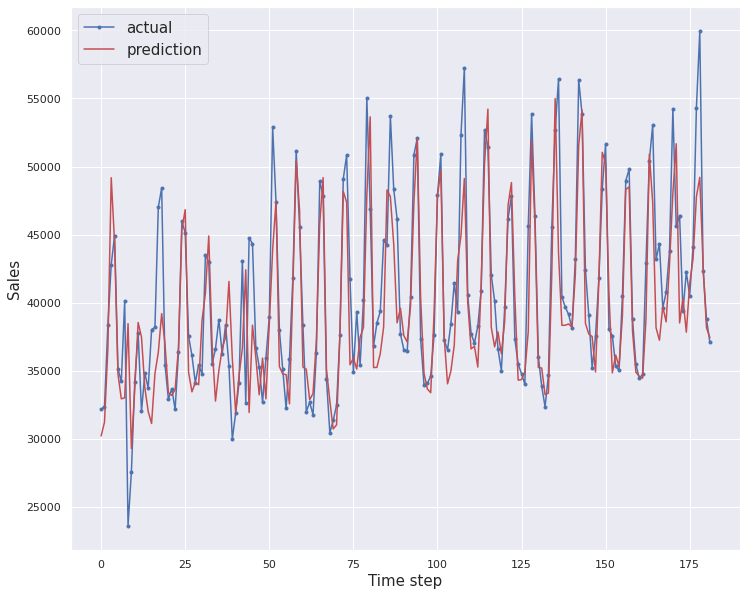

In [ ]:
train = (train_X, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (test_X, test_y)
print("Test dataset shape-",test[0].shape)
run_lstm(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window)

### Window - 7

In [ ]:
prediction_window = 7

In [ ]:
# Scale dataset

scaler, scaled = scale_data(sales_overall, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
print("Shape of reframed dataset-",reframed.shape)
#print(reframed)

Shape of scaled dataset- (1936, 1)
Shape of reframed dataset- (1923, 14)


In [ ]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


248

In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1736
182
(1736, 1, 7) (1736, 7) (182, 1, 7) (182, 7)


Train dataset shape- (1736, 1, 7)
Test dataset shape- (182, 1, 7)
Iteration-1
Test RMSE: 4558.450
MAPE: 8.420
Iteration-2
Test RMSE: 4614.793
MAPE: 8.472
Iteration-3
Test RMSE: 4622.725
MAPE: 8.470
Iteration-4
Test RMSE: 4666.996
MAPE: 8.556
Iteration-5
Test RMSE: 4649.372
MAPE: 8.480
Iteration-6
Test RMSE: 4604.117
MAPE: 8.401
Iteration-7
Test RMSE: 4590.850
MAPE: 8.365
Iteration-8
Test RMSE: 4565.142
MAPE: 8.338
Iteration-9
Test RMSE: 4608.390
MAPE: 8.461
Iteration-10
Test RMSE: 4588.467
MAPE: 8.471
Average MAPE for test data over 10 repetitions is 8.4434
Average RMSE for test data over 10 repetitions is 4606.9303


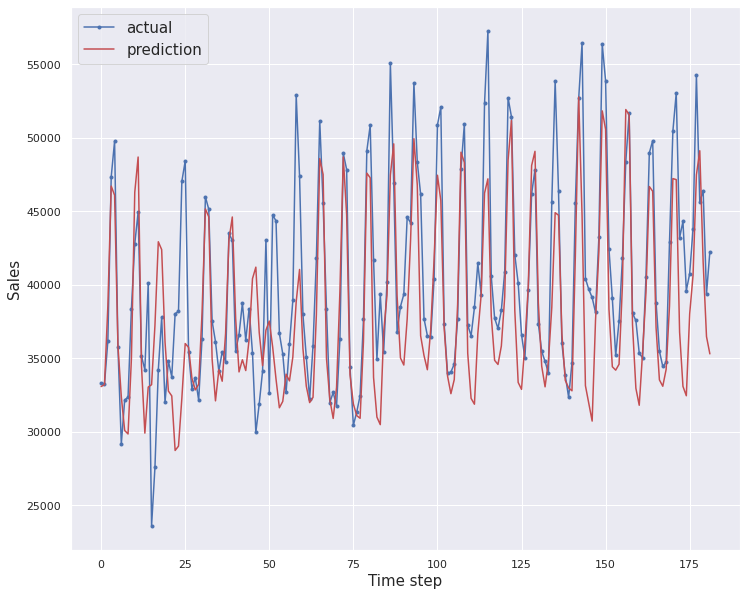

In [ ]:
train = (train_X, train_y)
print("Train dataset shape-",train[0].shape)
#raise Exception 
test = (test_X, test_y)
print("Test dataset shape-",test[0].shape)
run_lstm(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window)

## CNN

### Window - 1

In [ ]:
prediction_window = 1

In [ ]:
# Scale dataset

scaler, scaled = scale_data(sales_overall, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1936, 1)
Shape of reframed dataset- (1929, 8)


In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1736
182
(1736, 7) (1736, 1) (182, 7) (182, 1)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1736, 7, 1)
Validation set shape (182, 7, 1)


Train dataset shape- (1736, 7, 1)
Test dataset shape- (182, 7, 1)
Iteration-1
Test RMSE: 3723.826
MAPE: 6.877
Iteration-2
Test RMSE: 3877.207
MAPE: 7.417
Iteration-3
Test RMSE: 3835.908
MAPE: 7.144
Iteration-4
Test RMSE: 3864.087
MAPE: 7.058
Iteration-5
Test RMSE: 3900.823
MAPE: 7.086
Iteration-6
Test RMSE: 3977.376
MAPE: 7.291
Iteration-7
Test RMSE: 4008.920
MAPE: 7.384
Iteration-8
Test RMSE: 4025.319
MAPE: 7.300
Iteration-9
Test RMSE: 4051.221
MAPE: 7.433
Iteration-10
Test RMSE: 4055.414
MAPE: 7.402
Average MAPE for test data over 10 repetitions is 7.2392
Average RMSE for test data over 10 repetitions is 3932.0101


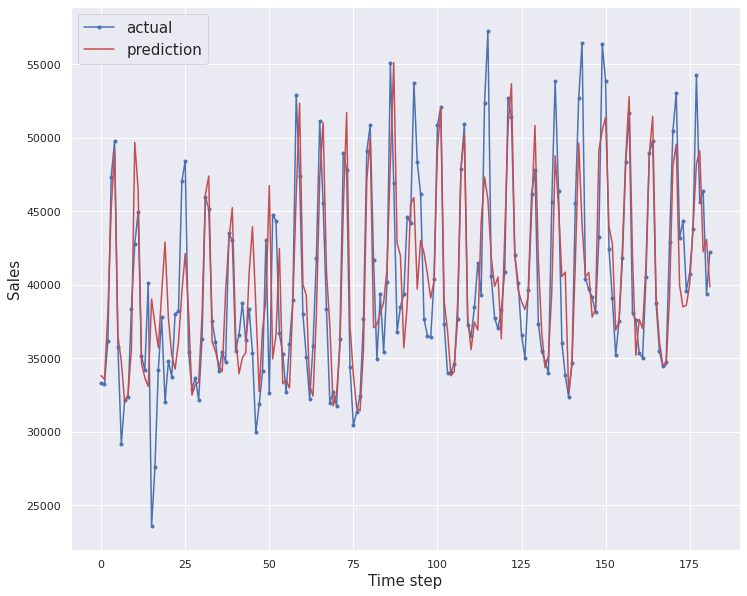

In [ ]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
run_cnn(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window)

### Window - 7

In [ ]:
prediction_window = 7

In [ ]:
# Scale dataset

scaler, scaled = scale_data(sales_overall, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1936, 1)
Shape of reframed dataset- (1923, 14)


In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1736
182
(1736, 7) (1736, 7) (182, 7) (182, 7)


In [ ]:
# reshape input to be 3D [samples, timesteps, features]
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1736, 7, 1)
Validation set shape (182, 7, 1)


Train dataset shape- (1736, 7, 1)
Test dataset shape- (182, 7, 1)
Iteration-1
Test RMSE: 4230.551
MAPE: 7.787
Iteration-2
Test RMSE: 4123.435
MAPE: 7.731
Iteration-3
Test RMSE: 4154.356
MAPE: 7.814
Iteration-4
Test RMSE: 4118.661
MAPE: 7.710
Iteration-5
Test RMSE: 4177.114
MAPE: 7.948
Iteration-6
Test RMSE: 4227.793
MAPE: 8.022
Iteration-7
Test RMSE: 4302.337
MAPE: 8.102
Iteration-8
Test RMSE: 4266.904
MAPE: 8.101
Iteration-9
Test RMSE: 4274.403
MAPE: 8.100
Iteration-10
Test RMSE: 4282.879
MAPE: 8.083
Average MAPE for test data over 10 repetitions is 7.9398
Average RMSE for test data over 10 repetitions is 4215.8431


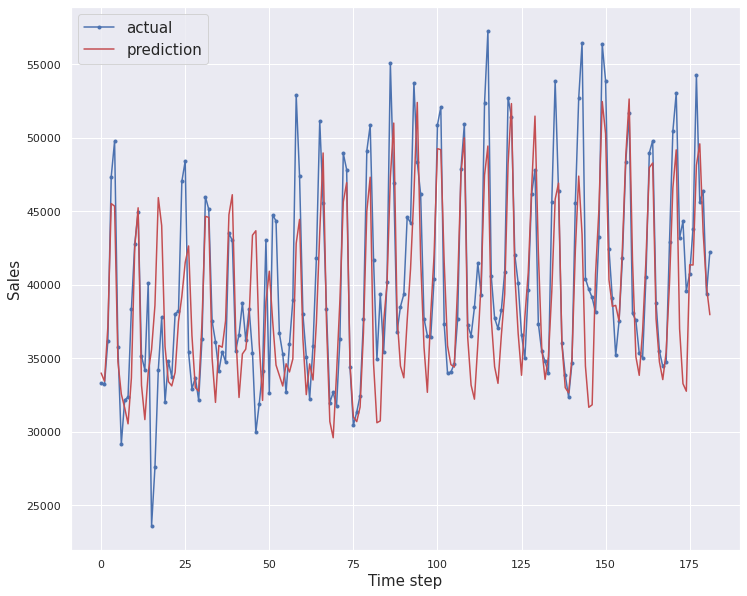

In [ ]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
run_cnn(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window)

## CNN + LSTM

### Window - 1

In [ ]:
prediction_window = 1

In [ ]:
# Scale dataset

scaler, scaled = scale_data(sales_overall, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1936, 1)
Shape of reframed dataset- (1929, 8)


In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1736
182
(1736, 7) (1736, 1) (182, 7) (182, 1)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1736, 7, 1)
Validation set shape (182, 7, 1)


In [ ]:
subsequences = 1
timesteps = train_X.shape[1]//subsequences
print(timesteps)
X_train_series_sub = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

7
Train set shape (1736, 1, 7, 1)
Validation set shape (182, 1, 7, 1)


Train dataset shape- (1736, 1, 7, 1)
Test dataset shape- (182, 1, 7, 1)
Iteration-1
Test RMSE: 3911.755
MAPE: 7.393
Iteration-2
Test RMSE: 3930.712
MAPE: 7.078
Iteration-3
Test RMSE: 3936.639
MAPE: 7.283
Iteration-4
Test RMSE: 4070.190
MAPE: 7.705
Iteration-5
Test RMSE: 3965.202
MAPE: 7.450
Iteration-6
Test RMSE: 3966.137
MAPE: 7.366
Iteration-7
Test RMSE: 3976.356
MAPE: 7.405
Iteration-8
Test RMSE: 3951.716
MAPE: 7.509
Iteration-9
Test RMSE: 4035.879
MAPE: 7.643
Iteration-10
Test RMSE: 4016.114
MAPE: 7.499
Average MAPE for test data over 10 repetitions is 7.4331
Average RMSE for test data over 10 repetitions is 3976.0700


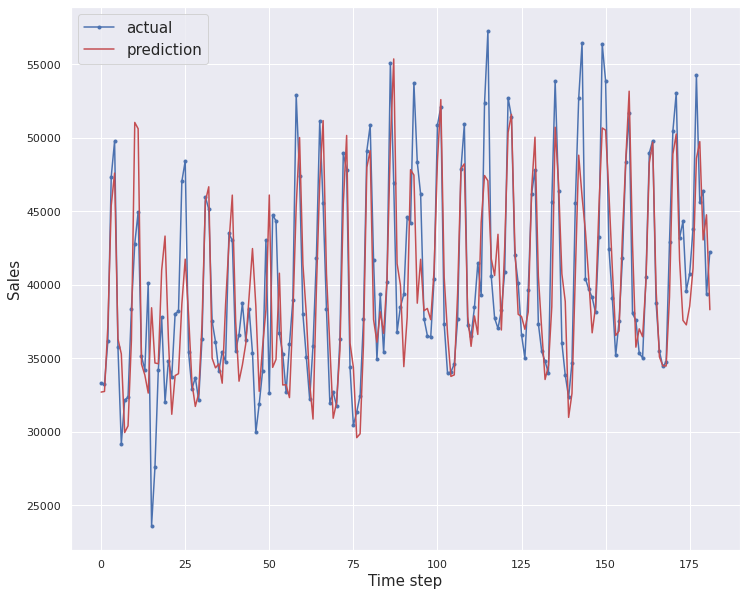

In [ ]:
train = (X_train_series_sub, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series_sub, test_y)
print("Test dataset shape-",test[0].shape)
run_cnn_lstm(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window)

### Window - 7

In [ ]:
prediction_window = 7

In [ ]:
# Scale dataset

scaler, scaled = scale_data(sales_overall, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1936, 1)
Shape of reframed dataset- (1923, 14)


In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1736
182
(1736, 7) (1736, 7) (182, 7) (182, 7)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1736, 7, 1)
Validation set shape (182, 7, 1)


In [ ]:
subsequences = 1
timesteps = train_X.shape[1]//subsequences
print(timesteps)
X_train_series_sub = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

7
Train set shape (1736, 1, 7, 1)
Validation set shape (182, 1, 7, 1)


Train dataset shape- (1736, 1, 7, 1)
Test dataset shape- (182, 1, 7, 1)
Iteration-1
Test RMSE: 4281.770
MAPE: 7.939
Iteration-2
Test RMSE: 4218.021
MAPE: 7.920
Iteration-3
Test RMSE: 4225.068
MAPE: 7.986
Iteration-4
Test RMSE: 4264.814
MAPE: 8.033
Iteration-5
Test RMSE: 4357.838
MAPE: 8.226
Iteration-6
Test RMSE: 4328.140
MAPE: 8.182
Iteration-7
Test RMSE: 4302.952
MAPE: 8.166
Iteration-8
Test RMSE: 4371.319
MAPE: 8.346
Iteration-9
Test RMSE: 4278.095
MAPE: 8.203
Iteration-10
Test RMSE: 4329.121
MAPE: 8.323
Average MAPE for test data over 10 repetitions is 8.1326
Average RMSE for test data over 10 repetitions is 4295.7139


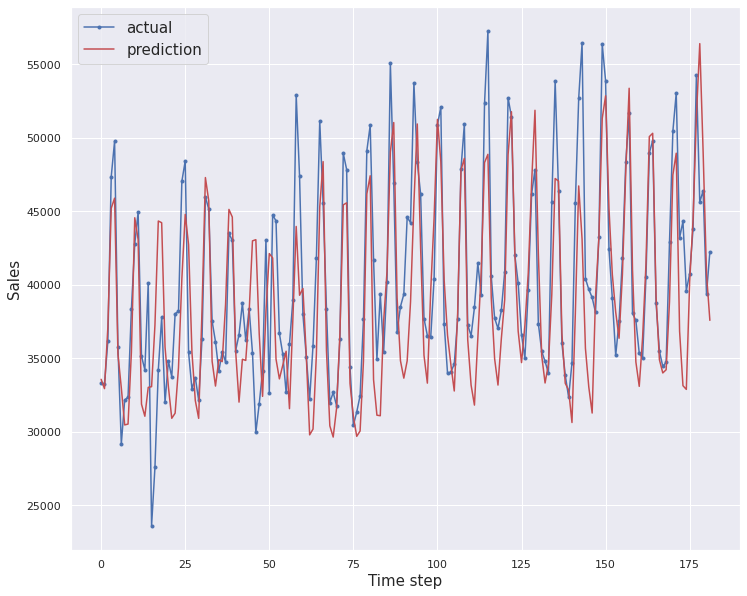

In [ ]:
train = (X_train_series_sub, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series_sub, test_y)
print("Test dataset shape-",test[0].shape)
run_cnn_lstm(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window)

## TCN

### Window - 1

In [ ]:
prediction_window = 1

In [ ]:
# Scale dataset

scaler, scaled = scale_data(sales_overall, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1936, 1)
Shape of reframed dataset- (1929, 8)


In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1736
182
(1736, 7) (1736, 1) (182, 7) (182, 1)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1736, 7, 1)
Validation set shape (182, 7, 1)


Train dataset shape- (1736, 7, 1)
Test dataset shape- (182, 7, 1)
Receptive field size = 61
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 128)               345728    
_________________________________________________________________
module_wrapper_35 (ModuleWra (None, 1)                 129       
Total params: 345,857
Trainable params: 345,857
Non-trainable params: 0
_________________________________________________________________
Iteration-1
Test RMSE: 4420.952
MAPE: 9.080
Iteration-2
Test RMSE: 4578.675
MAPE: 8.173
Iteration-3
Test RMSE: 4432.556
MAPE: 8.331
Iteration-4
Test RMSE: 4236.713
MAPE: 7.566
Iteration-5
Test RMSE: 4570.919
MAPE: 8.441
Iteration-6
Test RMSE: 4616.071
MAPE: 8.548
Iteration-7
Test RMSE: 4413.322
MAPE: 7.880
Iteration-8
Test RMSE: 4545.397
MAPE: 8.630
Iteration-9
Test RMSE: 4133.598
MAPE: 7.700
Iteration-10
Test RMSE

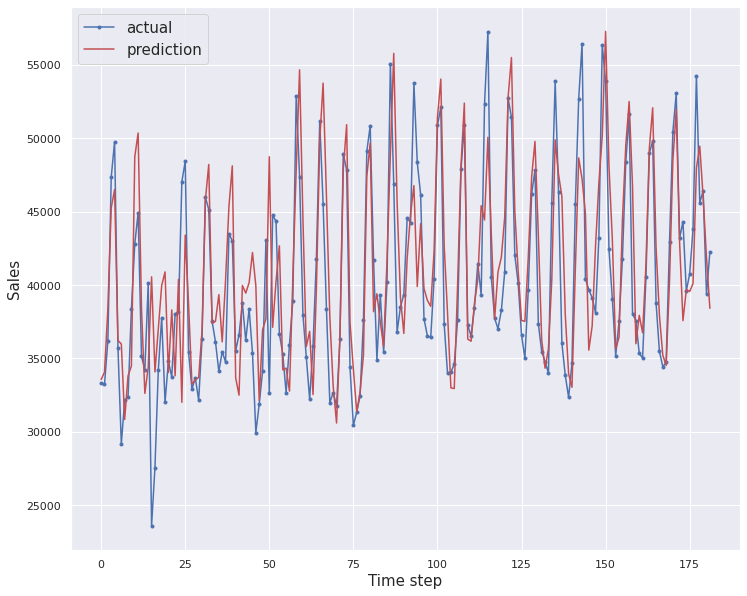

In [ ]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
run_tcn(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window)

### Window - 7

In [ ]:
prediction_window = 7

In [ ]:
# Scale dataset

scaler, scaled = scale_data(sales_overall, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1936, 1)
Shape of reframed dataset- (1923, 14)


In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1736
182
(1736, 7) (1736, 7) (182, 7) (182, 7)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1736, 7, 1)
Validation set shape (182, 7, 1)


Train dataset shape- (1736, 7, 1)
Test dataset shape- (182, 7, 1)
Receptive field size = 61
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_1 (TCN)                  (None, 128)               345728    
_________________________________________________________________
module_wrapper_36 (ModuleWra (None, 7)                 903       
Total params: 346,631
Trainable params: 346,631
Non-trainable params: 0
_________________________________________________________________
Iteration-1
Test RMSE: 4561.889
MAPE: 8.575
Iteration-2
Test RMSE: 4407.018
MAPE: 8.516
Iteration-3
Test RMSE: 4856.549
MAPE: 9.387
Iteration-4
Test RMSE: 4999.780
MAPE: 9.595
Iteration-5
Test RMSE: 5081.741
MAPE: 10.010
Iteration-6
Test RMSE: 4806.743
MAPE: 9.538
Iteration-7
Test RMSE: 4979.497
MAPE: 9.669
Iteration-8
Test RMSE: 4859.939
MAPE: 9.622
Iteration-9
Test RMSE: 4755.573
MAPE: 9.210
Iteration-10
Test RM

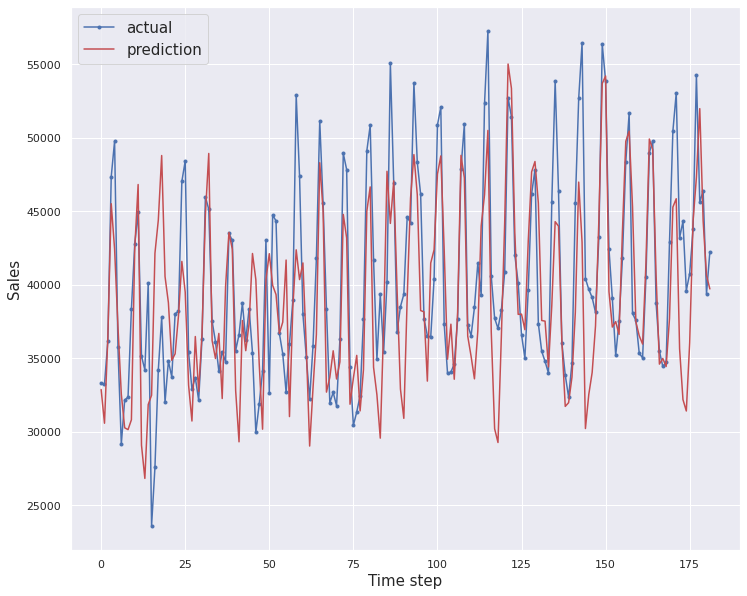

In [ ]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
run_tcn(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window)

## MACNN

### Window - 1

In [ ]:
prediction_window=1

In [ ]:
# Scale dataset

scaler, scaled = scale_data(sales_overall, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 28, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1936, 1)
Shape of reframed dataset- (1908, 29)


In [ ]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


246

In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1722
182
(1722, 28) (1722, 1) (182, 28) (182, 1)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1722, 28, 1)
Validation set shape (182, 28, 1)


#### WO Regularizer

Train dataset shape- (1722, 28, 1)
Test dataset shape- (182, 28, 1)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 28, 64)       960         series[0][0]                     
__________________________

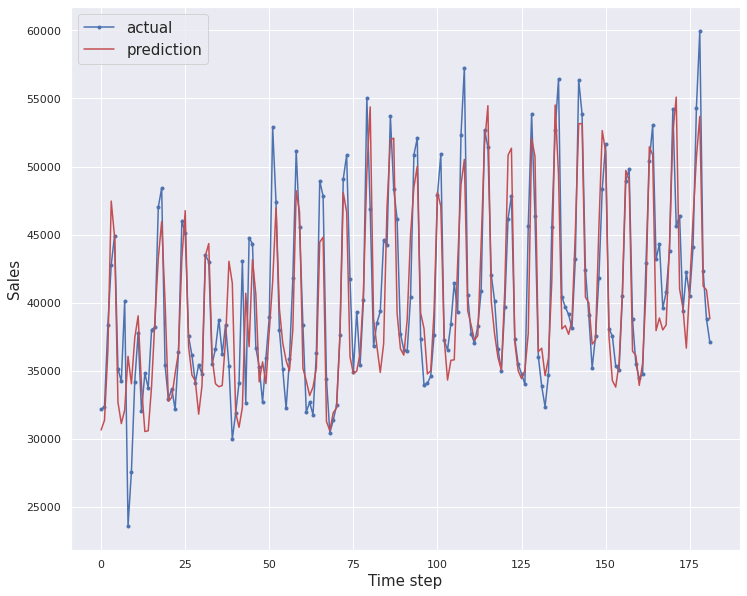

In [ ]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
run_macnn(train, test, n_repeats=10, epochs=20, verbose=0, n_in=28, window=prediction_window)

#### With Regularizer

(1722, 28, 1)
(182, 28, 1)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 28, 64)       960         series[0][0]                     
___________________________________________________________________

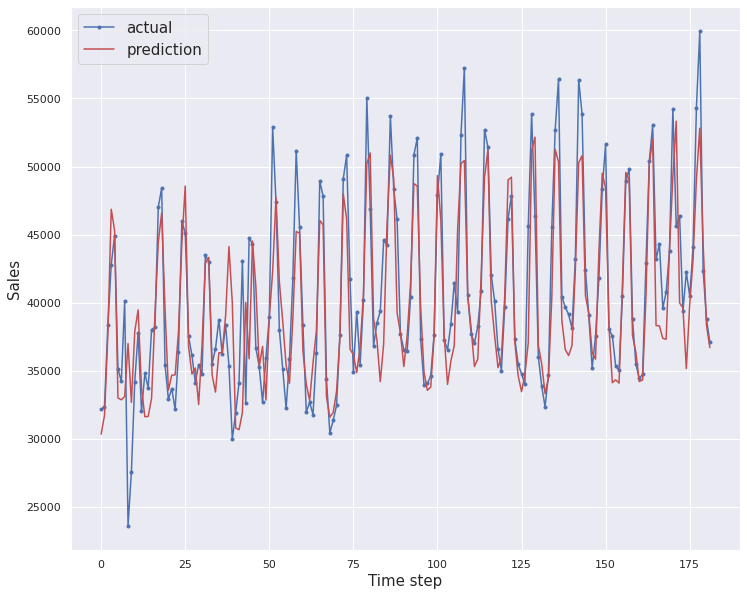

In [ ]:
train = (X_train_series, train_y)
print(train[0].shape)
#raise Exception
test = (X_valid_series, test_y)
print(test[0].shape)
run_macnn(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window, n_in=28, l2_regularizer=True)

### Window - 7

In [ ]:
prediction_window=7

In [ ]:
# Scale dataset

scaler, scaled = scale_data(sales_overall, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 28, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1936, 1)
Shape of reframed dataset- (1902, 35)


In [ ]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


245

In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1715
182
(1715, 28) (1715, 7) (182, 28) (182, 7)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1715, 28, 1)
Validation set shape (182, 28, 1)


#### WO Regularizer

Train dataset shape- (1715, 28, 1)
Test dataset shape- (182, 28, 1)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 28, 64)       960         series[0][0]                     
__________________________

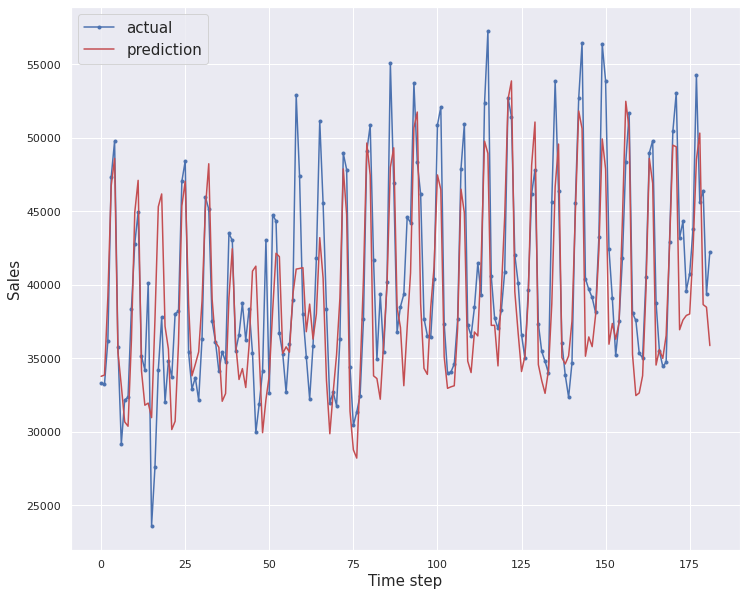

In [ ]:
train = (X_train_series, train_y)
print("Train dataset shape-",train[0].shape)
test = (X_valid_series, test_y)
print("Test dataset shape-",test[0].shape)
run_macnn(train, test, n_repeats=10, epochs=20, verbose=0, n_in=28, window=prediction_window)

#### With Regularizer

(1715, 28, 1)
(182, 28, 1)
Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 28, 64)       960         series[0][0]                     
___________________________________________________________________

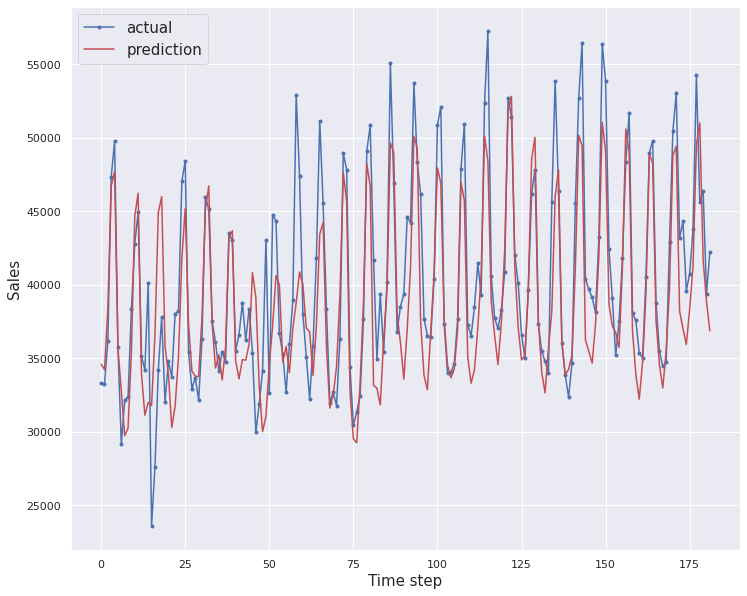

In [ ]:
train = (X_train_series, train_y)
print(train[0].shape)
#raise Exception
test = (X_valid_series, test_y)
print(test[0].shape)
run_macnn(train, test, n_repeats=10, epochs=20, verbose=0, window=prediction_window, n_in=28, l2_regularizer=True)